In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from scipy.stats import logistic
from scipy.stats import expon, uniform, laplace
from Main_functions import *

from My_DML import *
import random
from numpy import genfromtxt
import time

In [2]:
import dml
from dml.dml_eig import DML_eig

from __future__ import print_function, absolute_import
import numpy as np

from six.moves import xrange
from sklearn.utils.validation import check_X_y

from numpy.linalg import inv, eigh
import scipy.linalg as sl

from dml.dml_algorithm import DML_Algorithm
from dml.dml_utils import calc_outers, calc_outers_i

In [3]:
def mean_dist(X, Y, M):
    n = X.shape[0]
    S = 0
    for i in range(n):
        x, y = X[i], Y[i]
        dis_x_y_M = (x-y) @ M @ (x-y)
        S += dis_x_y_M
    return S/n


def pred_M(X, Y, M, t):
    n = X.shape[0]
    Pred = np.zeros(n, dtype = int)
    for i in range(n):
        x, y = X[i], Y[i]
        dis_x_y_M = (x-y) @ M @ (x-y)
        if dis_x_y_M >= t:
            Pred[i] = 1
        else: Pred[i] = 0
    return Pred

def acc(X, Y, D, M, t):
    P = pred_M(X, Y, M, t)
    return (P == D).sum()/X.shape[0]

def best_tau(X, Y, D, M):
    u = 2 * mean_dist(X, Y, M)
    mesh = np.linspace(start = 0, stop = u, num=100)
    best_acc = 0
    best_t = 0
    for t in mesh:
        acc_ = acc(X, Y, D, M, t = t)
        if acc_ > best_acc:
            best_acc = acc_
            best_t = t
    return best_t, best_acc 

### Setting the data distribuation 

Pairs $(x_i,y_i)\in \mathbb{R}^d\times \mathbb{R}^d$ for $i=1, \ldots, N$ are generated i.i.d. from density distribuation $f(\cdot)\times f(\cdot)$.  

Parameters:

$d:$ dimention of data points

$N:$ number of pairs

$f(\cdot):$ density distribuation


### Given the eigenvalues of ground truth $M_t$, we randomly generate it.

In [4]:
csv_path = 'CSVs/logistic_Eig_DML_'
image_path = 'Images/logistic_Eig_DML_'
title_suffix = '\n (Logistic Noise Eig_DML)'
noise_type = 'Logistic'
model_type = 'Logistic'

In [5]:
d = 10
rank = 5
seed = 2023

In [6]:
np.random.seed(seed)
non_zero_eigens_of_M_star = np.round(np.random.uniform(low=0.0, high=1.0, size= rank), 2)

In [7]:
#random.seed(seed)
# non_zero_eigens_of_M_star = random.choices(np.arange(1, 31), k = rank)
# random.uniform()
non_zero_eigens_of_M_star

array([0.32, 0.89, 0.59, 0.13, 0.14])

In [8]:
diag = np.zeros(d)
diag[:rank] = non_zero_eigens_of_M_star
diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [9]:
data_model = DG(diag, seed = 22)

Ground truth M_t and B_t are generated (M_t = B_t @ B_t.T)
To access to M_t and B_t, use .M_t and .B_t


In [10]:
data_model.M_diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [11]:
data_model.M_t.shape, data_model.B_t.shape

((10, 10), (10, 10))

### Given the eigenvalue of covariance matrix Cov, we randomly generate it.

In [12]:
np.random.seed(2024)
diag_cov = np.round(np.random.uniform(low=0.0, high=1.0, size= d), 2)

In [13]:
print(diag_cov)

[0.59 0.7  0.19 0.04 0.21 0.11 0.73 0.68 0.47 0.45]


In [14]:
# diag_cov.sort()

In [15]:
print(diag_cov)

[0.59 0.7  0.19 0.04 0.21 0.11 0.73 0.68 0.47 0.45]


In [16]:
diag_cov.sum()

4.17

In [17]:
Sigma, U_sigma = random_covariance(diag_cov, seed = 21)

In [18]:
f = multivariate_normal(mean = np.zeros(d), cov = Sigma)

### What is the average of squared norm of points generating where $x\sim f(x)$ with $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$

If $x\sim f(x)$ where $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$, then 
\begin{align}
\mathbb{E}\left(x^\top Mx\right) & = \mathbb{E}\left({\rm tr}(x^\top Mx)\right)\\
 & = \mathbb{E}\left({\rm tr}(xx^\top M)\right)\\
 & = {\rm tr}\left(\mathbb{E}\left(xx^\top\right)M\right)\\
 & = {\rm tr}\left(\left[{\rm Cov}(x) - \mathbb{E}(x)\mathbb{E}(x)^\top\right]M\right)
\end{align}

If we set  $\mu = \mathbf{0}$, then 
$$\mathbb{E}\left(x^\top Mx\right) = {\rm tr}\left(\Sigma M\right).$$
Therefore, since $x$ and $y$ are independent, 
$$\mathbb{E}\left(\|x-y\|_M^2\right) = 2{\rm tr}\left(\Sigma M\right).$$

$$\mathbb{E}\left((x-y)^\top (x-y)\right) = \mathbb{E}\left(x^\top x + y^\top y - x^\top y - y^\top x\right) = 2{\rm Cov}(x)$$

In [19]:
snm = 2 * np.trace(data_model.M_t @ Sigma)
print("squared norm mean = {}".format(snm))

squared norm mean = 1.6983720913430767


### Check the average empirically

In [20]:
N = 10000
X_1, Y_1 = sample(f, N)
sn = (((X_1 - Y_1) @ data_model.B_t)**2).sum()/N
print("emperical squared norm mean = {}".format(sn))

emperical squared norm mean = 1.7357384841106784


### Set $\tau$ to generate data points (binary case!)

In [21]:
tau = [1.3]
N = 15000
s = .2

In [22]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                                noise_type = noise_type, noise_par = s)

In [23]:
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.10026666666666667


In [24]:
for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i, (D_no_noisy==i).sum()))

number of pairs with 0 as their labels is 7586
number of pairs with 1 as their labels is 7414


In [25]:
(D_no_noisy== 0).sum()/N

0.5057333333333334

In [26]:
(D_noisy== 0).sum()/N

0.49293333333333333

In [27]:
def gen_S_D_and_X(X, Y, L):
    S = []
    D = []
    n, d = X.shape
    X_out = np.zeros((2*n, d))
    X_out[:n,:] = X
    X_out[n:,:] = Y
    for i in range(n):
        if L[i] == 1:
            D.append([i, n+i])
        else:
            S.append([i, n+i])
    return X_out, S, D

In [28]:
X_eig, Y_eig, D_noisy_eig, D_no_noisy_eig = X.copy(), Y.copy(), D_noisy.copy(), D_no_noisy.copy()
X_eig_test = X_eig[10000: 15000]
Y_eig_test = Y_eig[10000: 15000]
D_noisy_eig_test = D_noisy_eig[10000: 15000]
D_no_noisy_eig_test = D_no_noisy_eig[10000: 15000]

In [29]:
mu_list = [5e-3, 5e-3, 5e-3, 5e-3, 2e-3, 2e-3, 5e-4, 5e-4, 5e-4, 5e-4]

In [30]:
Eig_models = []
Eig_time = []
Eig_train_acc = []
Eig_test_acc_no_noisy = []
Best_tau = []
train_sizes = [100, 200, 400, 800, 1200, 1600, 2000, 2500, 3000, 3500]
for i in range(len(train_sizes)):
    N = train_sizes[i]
    mu = mu_list[i]
    print('N = {}'.format(N))
    print('mu = {}'.format(mu))    
    max_it = 5
    print('max_it = ', max_it)
    X_eig_train = X_eig[:N]
    Y_eig_train = Y_eig[:N]
    D_noisy_eig_train = D_noisy_eig[:N]
    D_no_noisy_eig_train = D_no_noisy_eig[:N]
    t = time.time()
    X_dml, S, D = gen_S_D_and_X(X_eig_train, Y_eig_train, D_noisy_eig_train)

    model = My_DML_eig(mu = mu, tol = 1e-5, eps = 1e-10, max_it = max_it)
    
    model.fit(X_dml, S, D)
    t_1 = time.time() - t
    Eig_time.append(t_1)
    Eig_models.append(model)
    t_best, best_train_acc = best_tau(X_eig, Y_eig, D_noisy_eig, model.metric())
    Eig_train_acc.append(best_train_acc)
    Best_tau.append(t_best)
    test_no_noisy_acc = acc(X_eig_test, Y_eig_test, D_no_noisy_eig_test, 
                            model.metric(), t = t_best)
    Eig_test_acc_no_noisy.append(test_no_noisy_acc)
    print(' run time = {}\n best_train_acc_noisy = {}\n test_no_noisy_acc = {}\n'.format(t_1, 
                                                                                         best_train_acc,
                                                                                         test_no_noisy_acc))  

N = 100
mu = 0.005
max_it =  5
 run time = 0.016972064971923828
 best_train_acc_noisy = 0.7557333333333334
 test_no_noisy_acc = 0.7768

N = 200
mu = 0.005
max_it =  5
 run time = 0.05720400810241699
 best_train_acc_noisy = 0.8046
 test_no_noisy_acc = 0.8254

N = 400
mu = 0.005
max_it =  5
 run time = 0.23214197158813477
 best_train_acc_noisy = 0.8274666666666667
 test_no_noisy_acc = 0.8524

N = 800
mu = 0.005
max_it =  5
 run time = 1.1006872653961182
 best_train_acc_noisy = 0.8482
 test_no_noisy_acc = 0.8828

N = 1200
mu = 0.002
max_it =  5
 run time = 5.03259801864624
 best_train_acc_noisy = 0.8466666666666667
 test_no_noisy_acc = 0.8818

N = 1600
mu = 0.002
max_it =  5
 run time = 78.58643460273743
 best_train_acc_noisy = 0.8466
 test_no_noisy_acc = 0.8752

N = 2000
mu = 0.0005
max_it =  5
 run time = 122.7017080783844
 best_train_acc_noisy = 0.8345333333333333
 test_no_noisy_acc = 0.86

N = 2500
mu = 0.0005
max_it =  5
 run time = 193.71743893623352
 best_train_acc_noisy = 0.845066

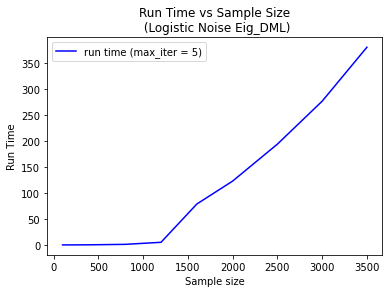

In [60]:
plt.plot(train_sizes, 
         Eig_time, 
         label = 'run time (max_iter = 5)', 
         color = 'blue')
plt.legend()
plt.xlabel('Sample size', fontsize = 10)
plt.ylabel('Run Time', fontsize = 10)
plt.title('Run Time vs Sample Size' + title_suffix, fontsize = 12)
plt.show()

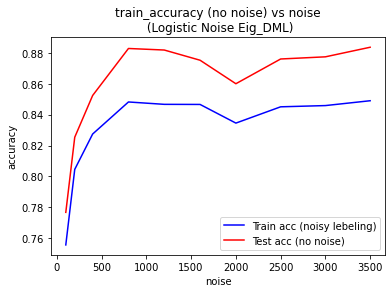

In [61]:
plt.plot(train_sizes, 
         Eig_train_acc, 
         label = 'Train acc (noisy lebeling)', 
         color = 'blue')
plt.plot(train_sizes, 
         Eig_test_acc_no_noisy, 
         label = 'Test acc (no noise)', 
         color = 'red')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('train_accuracy (no noise) vs noise' + title_suffix, fontsize = 12)
plt.show()

In [53]:
k = 10
n_labels = len(tau) + 1

In [54]:
X_torch = torch.tensor(X, dtype = torch.float64)
Y_torch = torch.tensor(Y, dtype = torch.float64)
D_noisy_torch = torch.tensor(D_noisy, dtype = torch.torch.int64)
D_no_noisy_torch = torch.tensor(D_no_noisy, dtype = torch.torch.int64)

In [55]:
X_test = X_torch[10000: 15000]
Y_test = Y_torch[10000: 15000]
D_noisy_test = D_noisy_torch[10000: 15000]
D_no_noisy_test = D_no_noisy_torch[10000: 15000]

In [56]:
My_models = []
My_time = []
My_train_acc = []
My_test_acc_no_noisy = []
for N in train_sizes:
    print('N = {}'.format(N))
    X_train = X_torch[:N]
    Y_train = Y_torch[:N]
    D_noisy_train = D_noisy_torch[:N]
    D_no_noisy_train = D_no_noisy_torch[:N]
    t = time.time()
    model = ML(d, k, n_labels, 
               X_train, Y_train, D_noisy_train, D_no_noisy_train, 
               X_test, Y_test, D_noisy_test, D_no_noisy_test, 
               Type = model_type)
    model.train(learning_rate = 5e-1, 
                n_iters = 501, 
                decay = .95,
                f = f, 
                B_star = data_model.B_t, 
                tau_star = data_model.tau_t, 
                N = 1000,
               show_log = False)
    t_1 = time.time() - t
    My_time.append(t_1)
    My_models.append(model)
    My_train_acc.append(model.test_accuracy_with_noise[-1])
    My_test_acc_no_noisy.append(model.test_accuracy_without_noise[-1])
    print(' run time = {}\n best_train_acc_noisy = {}\n test_no_noisy_acc = {}\n'.format(t_1, 
                                                                                        My_train_acc[-1],
                                                                                        My_test_acc_no_noisy[-1]))  

N = 100
 run time = 0.16746973991394043
 best_train_acc_noisy = 0.7958
 test_no_noisy_acc = 0.8148

N = 200
 run time = 0.17888188362121582
 best_train_acc_noisy = 0.8426
 test_no_noisy_acc = 0.8756

N = 400
 run time = 0.21789193153381348
 best_train_acc_noisy = 0.8734
 test_no_noisy_acc = 0.9156

N = 800
 run time = 0.30403685569763184
 best_train_acc_noisy = 0.887
 test_no_noisy_acc = 0.9432

N = 1200
 run time = 0.38399219512939453
 best_train_acc_noisy = 0.8998
 test_no_noisy_acc = 0.9672

N = 1600
 run time = 0.44687986373901367
 best_train_acc_noisy = 0.9036
 test_no_noisy_acc = 0.9734

N = 2000
 run time = 0.535822868347168
 best_train_acc_noisy = 0.9
 test_no_noisy_acc = 0.9718

N = 2500
 run time = 0.5884783267974854
 best_train_acc_noisy = 0.901
 test_no_noisy_acc = 0.9752

N = 3000
 run time = 0.6911349296569824
 best_train_acc_noisy = 0.9018
 test_no_noisy_acc = 0.9784

N = 3500
 run time = 0.8005969524383545
 best_train_acc_noisy = 0.905
 test_no_noisy_acc = 0.9788



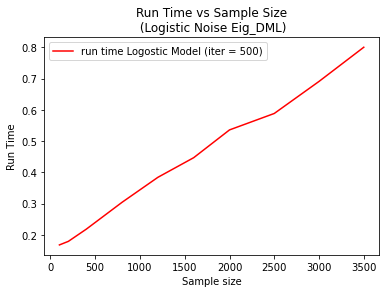

In [70]:
plt.plot(train_sizes, 
         My_time, 
         label = 'run time Logostic Model (iter = 500)', 
         color = 'red')
plt.legend()
plt.xlabel('Sample size', fontsize = 10)
plt.ylabel('Run Time', fontsize = 10)
plt.title('Run Time vs Sample Size' + title_suffix, fontsize = 12)
plt.show()

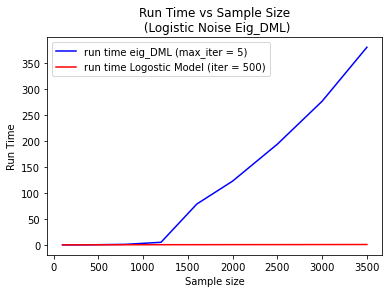

In [73]:
plt.plot(train_sizes, 
         Eig_time, 
         label = 'run time eig_DML (max_iter = 5)', 
         color = 'blue')
plt.plot(train_sizes, 
         My_time, 
         label = 'run time Logostic Model (iter = 500)', 
         color = 'red')
plt.legend()
plt.xlabel('Sample size', fontsize = 10)
plt.ylabel('Run Time', fontsize = 10)
plt.title('Run Time vs Sample Size' + title_suffix, fontsize = 12)
plt.savefig("Files/Logistic_and_eig_DML_Rum_times_vs_Sample_size_noisy_data_max_iter=5", bbox_inches='tight')
plt.show()

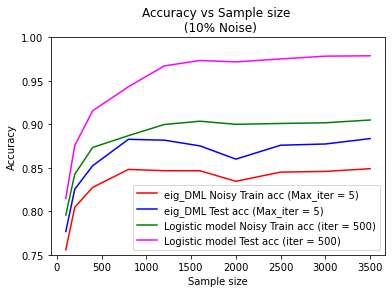

In [72]:
plt.plot(train_sizes, 
         Eig_train_acc, 
         label = 'eig_DML Noisy Train acc (Max_iter = 5)', color = 'red')
plt.plot(train_sizes, 
         Eig_test_acc_no_noisy, 
         label = 'eig_DML Test acc (Max_iter = 5)', color = 'blue')

plt.plot(train_sizes, 
         My_train_acc, 
         label = 'Logistic model Noisy Train acc (iter = 500)', color = 'green')
plt.plot(train_sizes, 
         My_test_acc_no_noisy, 
         label = 'Logistic model Test acc (iter = 500)', color = 'magenta')

plt.legend()
plt.xlabel('Sample size', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy vs Sample size \n (10% Noise)', fontsize = 12)
plt.ylim((0.75,1))
plt.savefig("Files/Logistic_and_eig_DML_Accuracy_vs_Sample_size_noisy_data_max_iter=5", bbox_inches='tight')
plt.show()